In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.metrics import Accuracy
device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'

In [20]:
(train_x, train_y), (test_x, test_y) = fashion_mnist.load_data()
train_x = np.expand_dims(train_x, axis=-1)
train_y = np.array(tf.keras.utils.to_categorical(train_y, 10))
test_x = np.expand_dims(test_x, axis=-1)
test_y = np.array(tf.keras.utils.to_categorical(test_y, 10))
train_x = train_x/255.0
test_x = test_x/255.0

In [21]:
def create_dataset(x, y):
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.batch(64).prefetch(1)
  return dataset

In [22]:
train_dataset = create_dataset(train_x, train_y)
val_dataset = create_dataset(test_x, test_y)

In [23]:
def my_model():
  input = Input(name='input', shape=(28,28,1))
  x = Conv2D(32, (3,3), activation='relu', name='first_conv')(input)
  x = MaxPool2D((2,2), name='first_maxpool')(x)
  x = Conv2D(64, (3,3), activation='relu', name='second_conv')(x)
  x = MaxPool2D((2,2), name='second_maxpool')(x)
  x = Flatten(name='flatten')(x)
  x = Dense(128, activation='relu', name='dense')(x)
  x = Dense(10, activation='softmax', name='output')(x)
  model = Model(inputs=input, outputs=x)
  return model

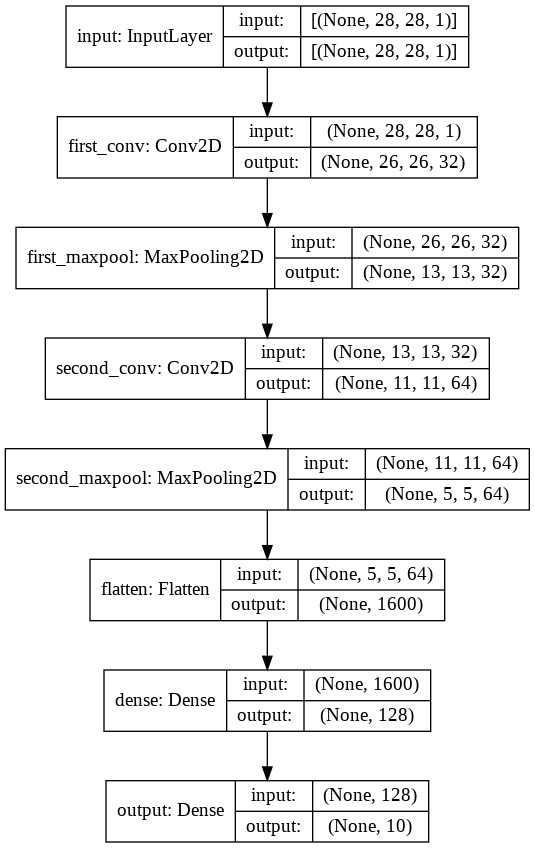

In [24]:
model = my_model()
plot_model(model, show_shapes=True)

In [65]:
loss = tf.keras.losses.categorical_crossentropy
optimizer = tf.keras.optimizers.RMSprop()
model.compile(loss=loss, optimizer=optimizer)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [66]:
def train_model(model, x, y, loss):
  with tf.GradientTape() as tape:
    current_loss = loss(y, model(x))
  gradients = tape.gradient(current_loss, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))
  return tf.math.reduce_mean(current_loss)
def train_one_epoch(model, dataset, loss):
  losses = []
  accuracy = [0.0]
  for step, single_batch in enumerate(dataset):
    loss_value = train_model(model, single_batch[0], single_batch[1], loss)
    losses.append(loss_value)
  for step, single_batch in enumerate(dataset):
    y_true = tf.argmax(single_batch[1], axis=1)
    y_pred = tf.argmax(model(single_batch[0]), axis=1)
    #accuracy.append(train_accuracy(y_true, y_pred))
  return losses, accuracy
def validation_loss_acc(model, dataset, loss):
  val_loasses = []
  val_accuracy = [0.0]
  for step, single_batch in enumerate(dataset):
    val_loasses.append(tf.math.reduce_mean(loss(single_batch[1], model(single_batch[0]))))
    y_true = tf.argmax(single_batch[1], axis=1)
    y_pred = tf.argmax(model(single_batch[0]), axis=1)
    #val_accuracy.append(accuracy_score(y_true, y_pred))
  return val_loasses, val_accuracy

In [90]:
@tf.function
def train(model, device, epochs):
  for epoch in range(epochs):
    #Train on GPU if available
    with tf.device(device_name=device):
      loss_value, train_accuracy = train_one_epoch(model, train_dataset, loss)
      val_loss, val_accuracy = validation_loss_acc(model, val_dataset, loss)
  return model_history

In [86]:
model = my_model()
model.compile(loss=loss, optimizer=optimizer)
model_history = train(model, 'CPU', 1)

In [89]:
model = my_model()
model.compile(loss=loss, optimizer=optimizer)
model_history = train(model, 'GPU', 1)

In [91]:
model = my_model()
model.compile(loss=loss, optimizer=optimizer)
model_history = train(model, 'GPU', 1)